# Import libraries

In [109]:
from datasets import load_dataset
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

## Import dataset from Huggingface

In [110]:
data = load_dataset("DFKI-SLT/few-nerd", "supervised")

# Split dataset to train, test and validation datasets

In [111]:
train_df = data["train"]
test_df = data["test"]
val_df = data["validation"]

 # Analysis of Mountain Entities

The function **calculate_mountain_summary** computes statistics related to mountain entities in a dataset. Specifically, it counts:

**num_mountains:** Total occurrences of a mountain tag in the dataset.
**mountains:** A set of unique mountain names found.
**num_samples_with_mountains:** The number of samples (rows) that contain at least one mountain.
The function is useful for analyzing the presence of mountains in a dataset, such as for named entity recognition (NER) tasks, where it's important to know how frequently certain entities (in this case, mountains) appear. It helps understand the data distribution and can assist in model training preparation by providing key statistics about the tagged mountains.

We need to identify which ner_tag is associated with mountain locations, as this will be used for Named Entity Recognition (NER) of mountain names.

![My Image](img/img.png) 
![My Image](img/img_1.png)
It was taken from the [link](https://huggingface.co/datasets/DFKI-SLT/few-nerd/blob/main/few-nerd.py)

In [112]:
mountain_tag = 24

In [113]:
def calculate_mountain_summary(dataset, mountain_tag):
    num_mountains = 0
    mountains = set()
    num_samples_with_mountains = 0

    for line in tqdm(dataset):
        tags = line['fine_ner_tags']
        mountain_indices = [i for i, tag in enumerate(tags) if tag == mountain_tag]
        
        if mountain_indices:
            num_samples_with_mountains += 1
        
        num_mountains += len(mountain_indices)
        mountains.update(line['tokens'][i] for i in mountain_indices)

    return num_mountains, len(mountains), num_samples_with_mountains

In [114]:
number_of_mounts_train, distinct_train, samples_train = calculate_mountain_summary(train_df, mountain_tag)

print(f"Total number of mountain tags in the training set: {number_of_mounts_train}")
print(f"Number of distinct mountains in the training set: {distinct_train}")
print(f"Number of samples containing mountains in the training set: {samples_train}")

100%|██████████| 131767/131767 [00:12<00:00, 10707.04it/s]

Total number of mountain tags in the training set: 4500
Number of distinct mountains in the training set: 1871
Number of samples containing mountains in the training set: 1502


In [115]:
number_of_mounts_test, distinct_test, samples_test = calculate_mountain_summary(test_df, mountain_tag)

print(f"Total number of mountain tags in the test set: {number_of_mounts_test}")
print(f"Number of distinct mountains in the test set: {distinct_test}")
print(f"Number of samples containing mountains in the test set: {samples_test}")


100%|██████████| 37648/37648 [00:03<00:00, 10578.84it/s]

Total number of mountain tags in the test set: 1366
Number of distinct mountains in the test set: 776
Number of samples containing mountains in the test set: 448


In [116]:
number_of_mounts_val, distinct_val, samples_val = calculate_mountain_summary(val_df, mountain_tag)

print(f"Total number of mountain tags in the validation set: {number_of_mounts_val}")
print(f"Number of distinct mountains in the validation set: {distinct_val}")
print(f"Number of samples containing mountains in the validation set: {samples_val}")


100%|██████████| 18824/18824 [00:01<00:00, 10474.34it/s]

Total number of mountain tags in the validation set: 734
Number of distinct mountains in the validation set: 474
Number of samples containing mountains in the validation set: 218


# Process the dataset

In this step, I need to implement a data preprocessing procedure to convert the fine-grained (NER) tags in the dataset into a binary format. The existing NER tags are transformed such that the tag representing mountains (identified by a numerical value, such as 24) is mapped to 1, while all other tags are mapped to 0. 

This binary representation simplifies the classification task for machine learning models, allowing for easier recognition of mountain-related entities. The code includes a flexible parameter, mountain_tag, making it adaptable to changes in the input data structure. By utilizing list comprehension and efficient mapping functions, the code is optimized for performance while maintaining clarity, ensuring a smoother preprocessing phase for training models that identify and classify mountain entities in text.

In [117]:
def mapper(example, mountain_tag):
    new_tags = [1 if tag == mountain_tag else 0 for tag in example["fine_ner_tags"]]
    example['fine_ner_tags'] = new_tags
    return example

def update(dataset, mountain_tag):
    return dataset.map(lambda example: mapper(example, mountain_tag),batched=False)

In [118]:
train_dataset = update(train_df,mountain_tag)
test_dataset = update(test_df,mountain_tag)
val_dataset = update(val_df,mountain_tag)

# Dataset Reduction and Balancing

This section focuses on reducing the size of the training, validation, and test datasets by filtering samples based on their content. It retains all samples that contain mountain entities and randomly selects a fraction of samples that do not contain mountains. This process aims to balance the dataset, ensuring that it includes a representative amount of relevant examples while maintaining a manageable size for effective model training and evaluation.

In [119]:
def reducer(dataset, p):
    def filter_data(example):
        if 1 in example['fine_ner_tags']:
            return True
        return np.random.uniform() < p

    return dataset.filter(filter_data)

In [120]:
num_rows_train = data['train'].num_rows
num_rows_test = data['test'].num_rows
num_rows_val = data['validation'].num_rows

In [121]:
fraction_train = samples_train / (num_rows_train - samples_train)
fraction_test = samples_test / (num_rows_test - samples_test)
fraction_val = samples_val / (num_rows_val - samples_val)

In [122]:
reduced_train = reducer(train_dataset, samples_train / (num_rows_train - samples_train))

In [123]:
reduced_test = reducer(test_dataset, samples_test / (num_rows_test- samples_test))

In [124]:
reduced_val = reducer(val_dataset, samples_val / (num_rows_val- samples_val))

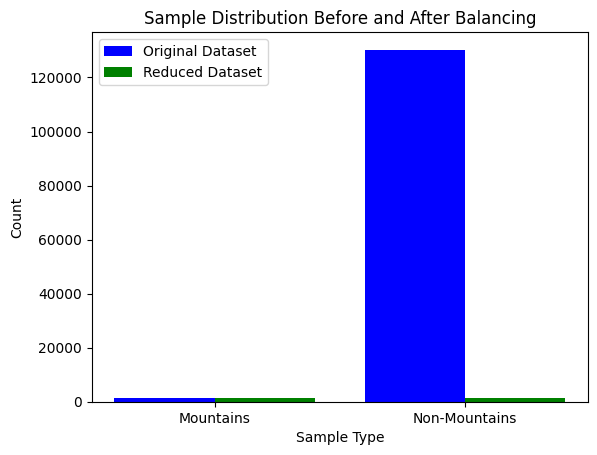

In [125]:
def plot_sample_distribution(train_dataset, reduced_train):
    original_mountains = sum(1 for example in train_dataset if 1 in example['fine_ner_tags'])
    original_non_mountains = len(train_dataset) - original_mountains

    reduced_mountains = sum(1 for example in reduced_train if 1 in example['fine_ner_tags'])
    reduced_non_mountains = len(reduced_train) - reduced_mountains

    categories = ['Mountains', 'Non-Mountains']
    original_counts = [original_mountains, original_non_mountains]
    reduced_counts = [reduced_mountains, reduced_non_mountains]

    x = range(len(categories))

    plt.bar(x, original_counts, width=0.4, label='Original Dataset', color='b', align='center')
    plt.bar([p + 0.4 for p in x], reduced_counts, width=0.4, label='Reduced Dataset', color='g', align='center')

    plt.xlabel('Sample Type')
    plt.ylabel('Count')
    plt.title('Sample Distribution Before and After Balancing')
    plt.xticks([p + 0.2 for p in x], categories)
    plt.legend()

    plt.show()

plot_sample_distribution(train_dataset, reduced_train)

In [126]:
calculate_mountain_summary(reduced_train,1)

100%|██████████| 3012/3012 [00:00<00:00, 5510.53it/s]


(4500, 1871, 1502)

In [127]:
calculate_mountain_summary(reduced_test,1)

100%|██████████| 905/905 [00:00<00:00, 5280.92it/s]


(1366, 776, 448)

In [128]:
calculate_mountain_summary(reduced_val,1)

100%|██████████| 415/415 [00:00<00:00, 6236.72it/s]


(734, 474, 218)

As we can see the number of samples containing mountains (tag 1) has remained unchanged. This is because during the balancing process, all samples with the mountain tag are retained, so their count stays the same. As a result, while the overall number of samples in the dataset decreases, the count of samples with mountains remains intact. This approach reduces the number of samples without mountains (tag 0), helping to maintain a balanced dataset while ensuring important information about mountains is preserved, which is crucial for training a model to correctly identify them in text.

# Saving the test, train, and validation datasets to the 'data' directory

In [130]:
reduced_train.save_to_disk("./data/train_data")
reduced_test.save_to_disk("./data/test_data")
reduced_val.save_to_disk("./data/val_data")

Saving the dataset (0/1 shards):   0%|          | 0/3012 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/905 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/415 [00:00<?, ? examples/s]